# GBP/USD Exchange Rate during 2017 UK Election Night - Under Construction



In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab

import tweepy

import json

import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\AlexH\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
CONSUMER_KEY = '4BByuBKYk19fpSl5iMIkju3c0'
CONSUMER_SECRET = '2EK91aT0s7uMJ1oWECBRUwkXrxGykigrsmtqtOIAvFBPXiucQq'
ACCESS_TOKEN = '892729320736739328-E30nIY5dacqxeugxPoe3TXB2fIjITZB'
ACCESS_TOKEN_SECRET = 'WMViNA7y1d1trkb5nt7L5dOAHdScmYBMHm33sLeUVZrWT'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

tweets_raw = api.user_timeline(screen_name = 'bbcelection', count = 200, include_rts = False)
for i in range(0,5):
    oldest=tweets_raw[-1].id
    new_tweets = api.user_timeline(screen_name = 'bbcelection',count=200,max_id=oldest)
    tweets_raw.extend(new_tweets)

data = [[tw.created_at.year, tw.created_at.month, tw.created_at.day,"%s.%s"%(tw.created_at.hour, tw.created_at.minute), tw.id_str, tw.text.encode("utf8")] for tw in tweets_raw ]
tweets=pd.DataFrame(data, columns=['year','month','date','time','tweet_id','tweet'])


In [311]:
# Wikipedia data
UKpoll = pd.read_csv('data/UK2017Poll.txt', sep='\t', header=0)
UKpoll.columns=['Con_poll', 'Lab_poll', 'Lib_poll','SNP_poll','Pla_poll','Greens_poll',\
                'UKIP_poll', 'Other_poll', 'Seat','Region','2015']
results = pd.read_csv("data/result.csv")

In [312]:
tweets.tweet=tweets.tweet.astype(str)
tweets_cleaned = tweets[tweets.tweet.str.contains('#GE2017')]
tweets_cleaned['time_full'] = tweets_cleaned["year"].map(str)+ "/"+ tweets_cleaned["month"].map(str) + \
    "/"+ tweets_cleaned["date"].map(str)  + "/"+ tweets_cleaned["time"].map(str) 

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Merging result data with time

In [313]:
results['time']=np.nan
for i in range(len(results)):
    tw = tweets_cleaned.tweet.str.contains(str(results.Constituency[i]))

    if True not in tw.tolist():
        
        #finds closes match
        max_score=0 
        for j in range(len(tweets_cleaned)):        
            score = fuzz.token_set_ratio(str(results.Constituency[i]),str(tweets_cleaned.tweet[j]))
            if score > max_score:
                tw_ind = j
                max_score=score
    else:
        tw_ind = tw.tolist().index(True)

        
    
    results['time'].loc[i]= datetime.strptime(tweets_cleaned.time_full[i],'%Y/%m/%d/%H.%M')
    
results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']]=results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']]/results['Total']

C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2984: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


ValueError: Columns must be same length as key

## Merging result data with time

In [325]:
full_table = pd.merge(results, UKpoll,  how='left', left_on='Constituency', right_on = 'Seat')
full_table = full_table.sort_values(by='time').reset_index(drop=True)

## Analysis

In [469]:
columns = ['time', 'Constituency','low', 'ave', 'high']
index= full_table.index
pred=pd.DataFrame(index=index, columns=columns)

sim_num = 100
for i in range(4,len(full_table)-7):
    
    #labour regression
    data_lab=full_table[['Lab_poll','Lab[c]','Total']][0:i].dropna(axis=0)
    X_lab=data_lab['Lab_poll']
    Y_lab=data_lab['Lab[c]']/data_lab['Total']
    X_lab=sm.add_constant(X_lab)
    model_lab = sm.RLM(Y_lab, X_lab,missing = 'drop').fit()
    
    #extract parameters
    const_lab = np.random.normal(model_lab.params[0], model_lab.bse[0], sim_num)
    slope_lab = np.random.normal(model_lab.params[1], model_lab.bse[1], sim_num)
    
    #Conservatives regression
    data_con=full_table[['Con_poll','Con[b]','Total']][0:i].dropna(axis=0)
    X_con=data_con['Con_poll']
    Y_con=data_con['Con[b]']/data_con['Total']
    X_con=sm.add_constant(X_con)
    model_con = sm.RLM(Y_con, X_con).fit()
    
    #extract parameters
    const_con = np.random.normal(model_con.params[0], model_con.bse[0], sim_num)
    slope_con = np.random.normal(model_con.params[1], model_con.bse[1], sim_num)
    
    #Liberal Regression
    data_lib=full_table[['Lib_poll','LD','Total']][0:i].dropna(axis=0)
    X_lib=data_lib['Lib_poll']
    Y_lib=data_lib['LD']/data_lib['Total']
    X_lib=sm.add_constant(X_lib)
    model_lib = sm.RLM(Y_lib, X_lib).fit()
    
    #extract parameters
    const_lib = np.random.normal(model_lib.params[0], model_lib.bse[0], sim_num)
    slope_lib = np.random.normal(model_lib.params[1], model_lib.bse[1], sim_num)
    
    #SNP Regression
    #SNP has no votes and poll in many regions, assign 0 to model in this case
    full_table['SNP']=full_table['SNP'].fillna(0)
    data_snp=full_table[['SNP_poll','SNP','Total']][0:i].dropna(axis=0)
    X_snp=data_snp['SNP_poll']
    Y_snp=data_snp['SNP']/data_snp['Total']
    X_snp=sm.add_constant(X_snp)
    model_snp = sm.RLM(Y_snp, X_snp).fit()
    
    #extract parameters
    if np.isnan(model_snp.params[0]):
        const_snp = 0
        slope_snp = 0
    else:
        const_snp = np.random.normal(model_snp.params[0], model_snp.bse[0], sim_num)
        slope_snp = np.random.normal(model_snp.params[1], model_snp.bse[1], sim_num)
    

    
    result = np.zeros([sim_num, len(full_table)-i])
    
    #Sampling the regression parameters to generate predicted outcome
    for j in range(0, len(const_lab)):
        
        #Labour
        error_lab = np.random.normal(np.mean(model_lab.resid), np.std(model_lab.resid), sim_num)
        result_lab = np.array([v + const_lab[j] + slope_lab[j]*np.array(full_table['Lab_poll'][i:]) for v in error_lab])
        
        #Conservative
        error_con = np.random.normal(np.mean(model_con.resid), np.std(model_con.resid), sim_num)
        result_con = np.array([v + const_con[j] + slope_con[j]*np.array(full_table['Con_poll'][i:]) for v in error_con])
        
        #Liberal
        error_lib = np.random.normal(np.mean(model_lib.resid), np.std(model_lib.resid), sim_num)
        result_lib = np.array([v + const_lib[j] + slope_lib[j]*np.array(full_table['Lib_poll'][i:]) for v in error_lib])
        
        #SNP
        if not np.isnan(model_snp.params[0]):
            error_snp = np.random.normal(np.mean(model_snp.resid), np.std(model_snp.resid), sim_num)
            result_snp = np.array([v + const_snp[j] + slope_snp[j]*np.array(full_table['SNP_poll'][i:]) for v in error_snp])
        else:
            #no data
            result_snp = 0
        
        result_temp = (result_con>result_lab) & (result_con>result_lib) & (result_con>result_snp) 
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=len(full_table.Party[0:i][full_table.Party=='Con'])+ np.count_nonzero(result, axis=1)
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot
    pred.time[i]=full_table.time[i]
    pred.Constituency[i]=full_table.Constituency[i]
    pred.low[i]=np.mean(EEV)-np.std(EEV)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.mean(EEV)+np.std(EEV)

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:171: RuntimeWarning: invalid value encountered in true_divide
  tmp_results.scale).sum()
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:284: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
C:\Users\AlexH\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)
C:\Users\AlexH\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:267: RuntimeWarning: invalid value encountered in less_equal
  return np

In [417]:
pred

,time,Constituency,low,ave,high
0,2017-06-09 00:59:00,Wycombe,275.233,305.81,336.387
1,2017-06-09 01:01:00,Wrexham,263.531,299.815,336.099
2,2017-06-09 01:02:00,Worsley and Eccles South,256.253,340.3,424.347
3,2017-06-09 01:03:00,Worcester,239.783,316.517,393.252
4,2017-06-09 01:04:00,Wolverhampton North East,285.337,332.31,379.283
5,2017-06-09 01:05:00,Witney,275.492,321.885,368.278
6,2017-06-09 01:07:00,Wirral West,278.774,317.887,357.001
7,2017-06-09 01:08:00,Wimbledon,266.404,313.145,359.886
8,2017-06-09 01:10:00,Weston-Super-Mare,279.809,315.863,351.916
9,2017-06-09 01:14:00,Westminster North,275.435,324.66,373.885


In [450]:
fx = pd.read_csv('data/FX data.csv',header=None,sep='\;')

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[5], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:4].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]
fx['time'] = [datetime.strptime(v, '%Y%m%d %H%M%S') for v in fx['time']]

#change time to UTC to match twitter
fx['time'] = [v + timedelta(hours=5) for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:5],1)
fx

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


,mean
time,
2017-06-09 00:59:00,1.272360
2017-06-09 01:00:00,1.272880
2017-06-09 01:01:00,1.273857
2017-06-09 01:02:00,1.273683
2017-06-09 01:03:00,1.273943
2017-06-09 01:04:00,1.274313
2017-06-09 01:05:00,1.273993
2017-06-09 01:06:00,1.274067
2017-06-09 01:07:00,1.275213


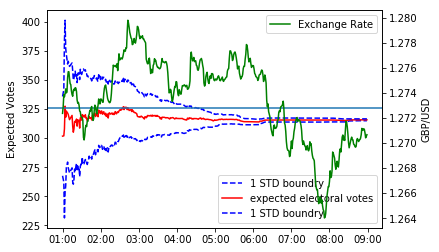

In [470]:
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='1 STD boundry')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes')
ax1.plot_date(pred.time, pred.high,'b--', label='1 STD boundry')
plt.ylabel('Expected Votes')
pylab.legend(loc='lower right')
plt.axhline(y=326)

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('GBP/USD')
plt.xlabel('UTC Time')
pylab.legend(loc='upper right')


plt.show()


In [4]:
tweets

,year,month,date,time,tweet_id,tweet
0,2017,6,9,20.26,873275224090980352,"b'All the votes are counted, all the results a..."
1,2017,6,9,20.23,873274411654238209,b'Kensington: LAB win #GE2017. Full results: h...
2,2017,6,9,16.44,873219358939590656,"b'CORRECTION: Updated figures Southend West, C..."
3,2017,6,9,15.14,873196528923533312,b'Update: Correcting LAB number of votes. Winc...
4,2017,6,9,9.40,873112674753630212,b'Update 10:40am: Latest seat totals by party ...
5,2017,6,9,9.40,873112632907018240,"b'Updated result: Wells, CON hold #GE2017. See..."
6,2017,6,9,9.38,873112128621641729,b'CORRECTION: Updated image Redditch CON hold ...
7,2017,6,9,8.59,873102302113964033,b'Update 9:59am: Latest seat totals by party #...
8,2017,6,9,8.49,873099783061164033,b'Update 9:49am: Latest seat totals by party #...
9,2017,6,9,8.31,873095205984944129,b'Update 9:31am: Latest seat totals by party #...


In [ ]:
plt.plot()